## Assignment 3 Pattern Mining and Recommender Systems: Individual Code

### Task 1: Pattern mining

### Chia-Hao Lo, 1907385, Version 05

### 1. Data Loading

#### 1.1 Environment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import networkx as nx
from sklearn.preprocessing import MinMaxScaler


#### 1.2 Loading the data

In [2]:
df_train = pd.read_csv('./data/Groceries data train.csv')
print(df_train.shape)
print(df_train.head())


(26985, 7)
   User_id       Date itemDescription    year  month  day  day_of_week
0   2351.0  1/01/2014         cleaner  2014.0    1.0  1.0          2.0
1   2226.0  1/01/2014         sausage  2014.0    1.0  1.0          2.0
2   1922.0  1/01/2014  tropical fruit  2014.0    1.0  1.0          2.0
3   2943.0  1/01/2014      whole milk  2014.0    1.0  1.0          2.0
4   1249.0  1/01/2014    citrus fruit  2014.0    1.0  1.0          2.0


In [3]:
df_train.info()
df_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26985 entries, 0 to 26984
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   User_id          19382 non-null  float64
 1   Date             19382 non-null  object 
 2   itemDescription  19382 non-null  object 
 3   year             19382 non-null  float64
 4   month            19382 non-null  float64
 5   day              19382 non-null  float64
 6   day_of_week      19382 non-null  float64
dtypes: float64(5), object(2)
memory usage: 1.4+ MB


,User_id,year,month,day,day_of_week
count,19382.000000,19382.000000,19382.000000,19382.000000,19382.000000
mean,3009.050769,2014.057012,6.166134,15.391342,3.023785
std,1158.135945,0.231871,3.572992,8.750628,1.994446
min,1000.000000,2014.000000,1.000000,1.000000,0.000000
25%,1998.000000,2014.000000,3.000000,8.000000,1.000000
50%,3015.500000,2014.000000,6.000000,15.000000,3.000000
75%,4025.000000,2014.000000,9.000000,23.000000,5.000000
max,5000.000000,2015.000000,12.000000,31.000000,6.000000


In [4]:
print(df_train.nunique())

User_id            3493
Date                384
itemDescription     167
year                  2
month                12
day                  31
day_of_week           7
dtype: int64


In [5]:
# Make feature names consistent
df_train.columns = df_train.columns.str.lower()

#### 1.3 Finding missing values

Here we will try to find out the missing values and try to fix the missing values if they are MAR.

In [6]:
missing_train = df_train.isnull().sum()
print(missing_train)


user_id            7603
date               7603
itemdescription    7603
year               7603
month              7603
day                7603
day_of_week        7603
dtype: int64


In [7]:
print(df_train[df_train.isnull().any(axis=1)])

       user_id date itemdescription  year  month  day  day_of_week
19382      NaN  NaN             NaN   NaN    NaN  NaN          NaN
19383      NaN  NaN             NaN   NaN    NaN  NaN          NaN
19384      NaN  NaN             NaN   NaN    NaN  NaN          NaN
19385      NaN  NaN             NaN   NaN    NaN  NaN          NaN
19386      NaN  NaN             NaN   NaN    NaN  NaN          NaN
...        ...  ...             ...   ...    ...  ...          ...
26980      NaN  NaN             NaN   NaN    NaN  NaN          NaN
26981      NaN  NaN             NaN   NaN    NaN  NaN          NaN
26982      NaN  NaN             NaN   NaN    NaN  NaN          NaN
26983      NaN  NaN             NaN   NaN    NaN  NaN          NaN
26984      NaN  NaN             NaN   NaN    NaN  NaN          NaN

[7603 rows x 7 columns]


From the columns we found out after 1932 rows, 7603 rows of the data are missing, we will drop these rows and continue with next step.

In [8]:
df_train = df_train.dropna()

We removed na data.

In [9]:
print(df_train.isnull().sum())

user_id            0
date               0
itemdescription    0
year               0
month              0
day                0
day_of_week        0
dtype: int64


In [10]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 19382 entries, 0 to 19381
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          19382 non-null  float64
 1   date             19382 non-null  object 
 2   itemdescription  19382 non-null  object 
 3   year             19382 non-null  float64
 4   month            19382 non-null  float64
 5   day              19382 non-null  float64
 6   day_of_week      19382 non-null  float64
dtypes: float64(5), object(2)
memory usage: 1.2+ MB
None


Now there are 19382 rows of train data left, we will use them to be our data. This number is close to the number 19300 records provided from the assignment instructions. 

### 2. EDA

In [11]:
print("Unique Users in training:\t",df_train['user_id'].nunique())
print("Unique Items in training:\t",df_train['itemdescription'].nunique())


Unique Users in training:	 3493
Unique Items in training:	 167


In [12]:
df_train['itemdescription'].value_counts().head(10)

itemdescription
whole milk          1135
other vegetables     916
rolls/buns           878
soda                 816
yogurt               678
bottled water        525
root vegetables      512
shopping bags        455
pastry               421
tropical fruit       410
Name: count, dtype: int64

In [13]:
df_train['itemdescription'].value_counts().tail(10)

itemdescription
hair spray               5
salad dressing           4
whisky                   4
rubbing alcohol          3
make up remover          3
frozen chicken           2
bags                     1
preservation products    1
kitchen utensil          1
baby cosmetics           1
Name: count, dtype: int64

Here we can see that there are 167 items in the train dataset itemDescription and above columns show the top 10 and bottom 10 items.

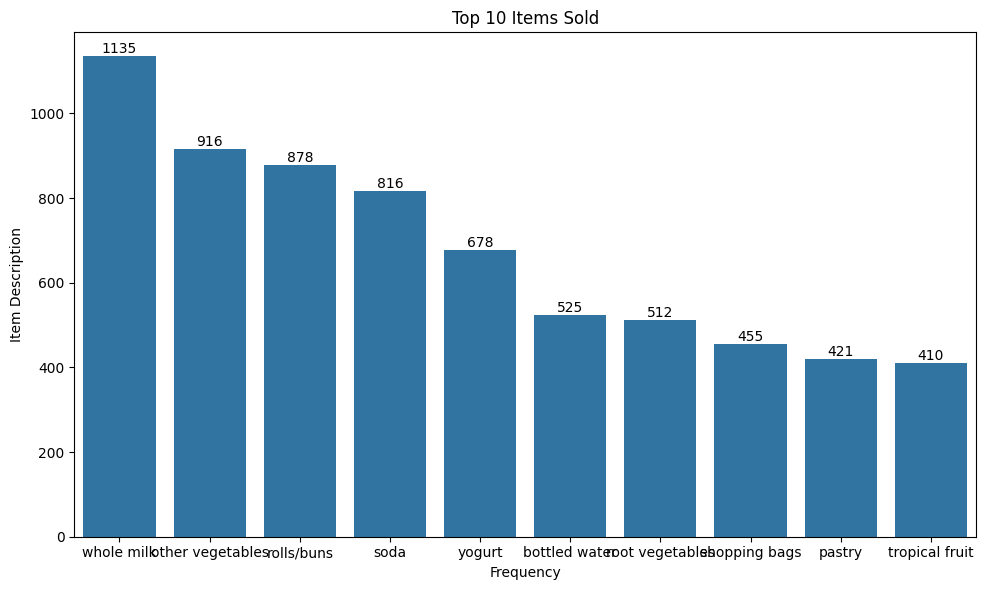

In [14]:
# Top 10 items sold in training data
item_distribution = df_train['itemdescription'].value_counts().reset_index(name='frequency')
item_distribution = item_distribution.rename(columns={'index': 'itemdescription'})
item_distribution = item_distribution.sort_values(by='frequency', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='itemdescription', y='frequency', data=item_distribution)
plt.title('Top 10 Items Sold')
plt.xlabel('Frequency')
plt.ylabel('Item Description')
for index, row in item_distribution.iterrows():
    plt.text(index, row['frequency'], row['frequency'], ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()


This graph shows the top 10 products of the store.

In [15]:
# Lowest 10 items sold in training data
item_distribution = df_train['itemdescription'].value_counts().reset_index(name='frequency')
item_distribution = item_distribution.sort_values(by='frequency', ascending=True).head(10)
item_distribution

,itemdescription,frequency
166,baby cosmetics,1
163,bags,1
165,kitchen utensil,1
164,preservation products,1
162,frozen chicken,2
160,rubbing alcohol,3
161,make up remover,3
159,whisky,4
158,salad dressing,4
157,hair spray,5


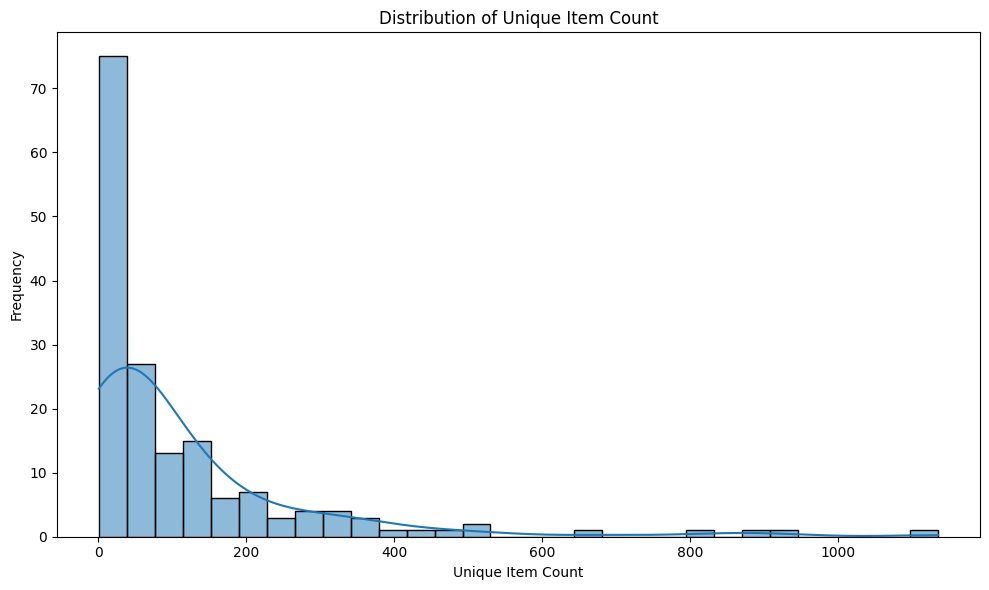

In [16]:
# Distribution of unique item count
plt.figure(figsize=(10, 6))
sns.histplot(df_train['itemdescription'].value_counts(), bins=30, kde=True)
plt.title('Distribution of Unique Item Count')
plt.xlabel('Unique Item Count')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

This histogram shows the distribution of unique item frequencies in the dataset. Most items appear rarely, but a few of items are very frequent, it shows a long-tail distribution.

3493
5.235614085313484


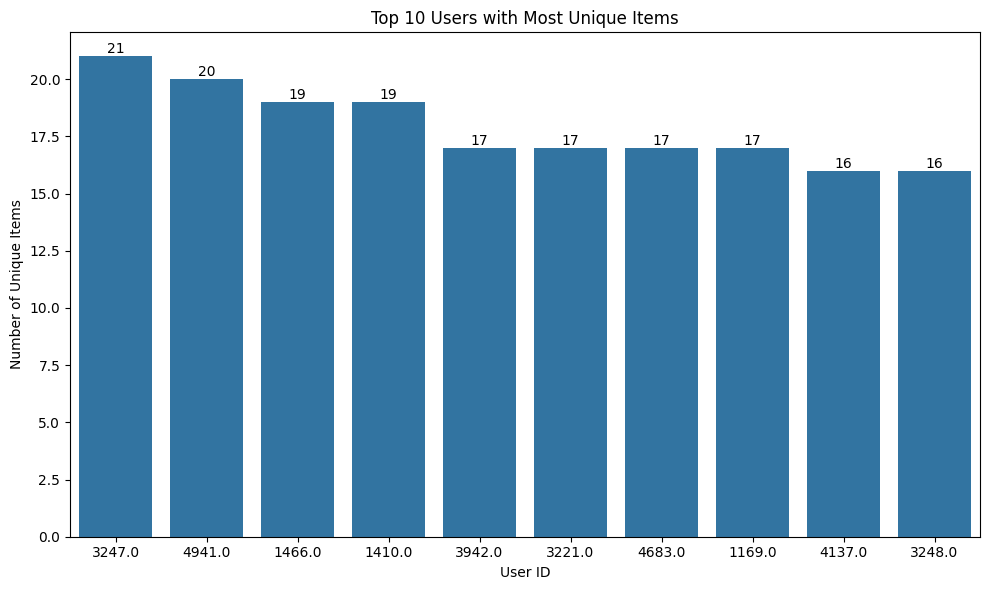

In [17]:
# User Behavior (Top 10 Users with Most Unique Items)
user_basket_counts = df_train.groupby('user_id')['itemdescription'].nunique()
number_of_users = len(user_basket_counts)
avg_basket_per_user = user_basket_counts.mean()
top_users = user_basket_counts.sort_values(ascending=False).head(10)
print(number_of_users)
print(avg_basket_per_user)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_users.index, y=top_users.values, order=top_users.index)
plt.title('Top 10 Users with Most Unique Items')
plt.xlabel('User ID')
plt.ylabel('Number of Unique Items')
for index, value in enumerate(top_users):
    plt.text(index, value, str(value), ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

Here we checked the user behavior and we get there are total 3493 users and for average purchasing items are 5.24. In the column we can find the top 10 users.

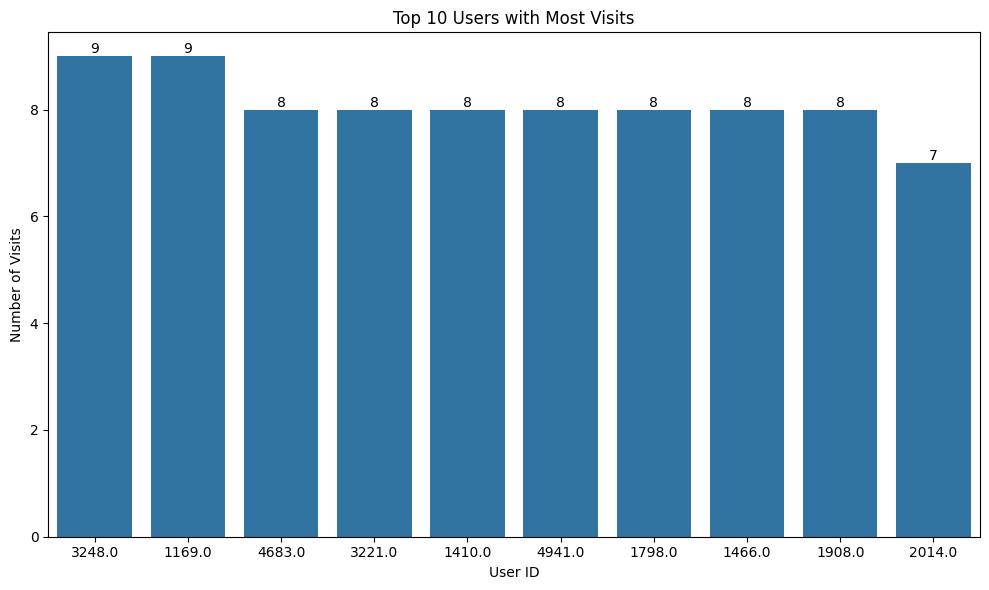

In [18]:
#  User Behavior(Top 10 Users with Most Visits)
user_visits = df_train.groupby('user_id')['date'].nunique()
most_frequent_users = user_visits.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=most_frequent_users.index, y=most_frequent_users.values, order=most_frequent_users.index)
plt.title('Top 10 Users with Most Visits')
plt.xlabel('User ID')
plt.ylabel('Number of Visits')
for index, value in enumerate(most_frequent_users):
    plt.text(index, value, str(value), ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

This graph shows the top 10 visits customers.

<Figure size 1400x700 with 0 Axes>

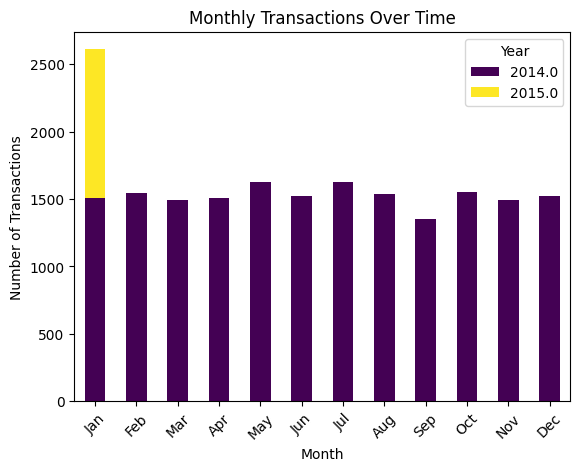

In [19]:
# Grouping by year and month
monthly_counts = df_train.groupby(['year', 'month']).size().unstack()

plt.figure(figsize=(14, 7))
monthly_counts.T.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Monthly Transactions Over Time')
plt.xlabel('Month')
plt.xticks(ticks=range(len(monthly_counts.columns)), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Number of Transactions')
plt.legend(title='Year')
plt.xticks(rotation=45)
plt.show()

The chart shows the number of purchasing monthy.

,day_of_week,itemdescription,count
0,0.0,whole milk,165
1,0.0,rolls/buns,128
2,0.0,soda,119
3,0.0,other vegetables,106
4,0.0,yogurt,101
5,1.0,other vegetables,150
6,1.0,whole milk,147
7,1.0,rolls/buns,117
8,1.0,soda,110
9,1.0,yogurt,93


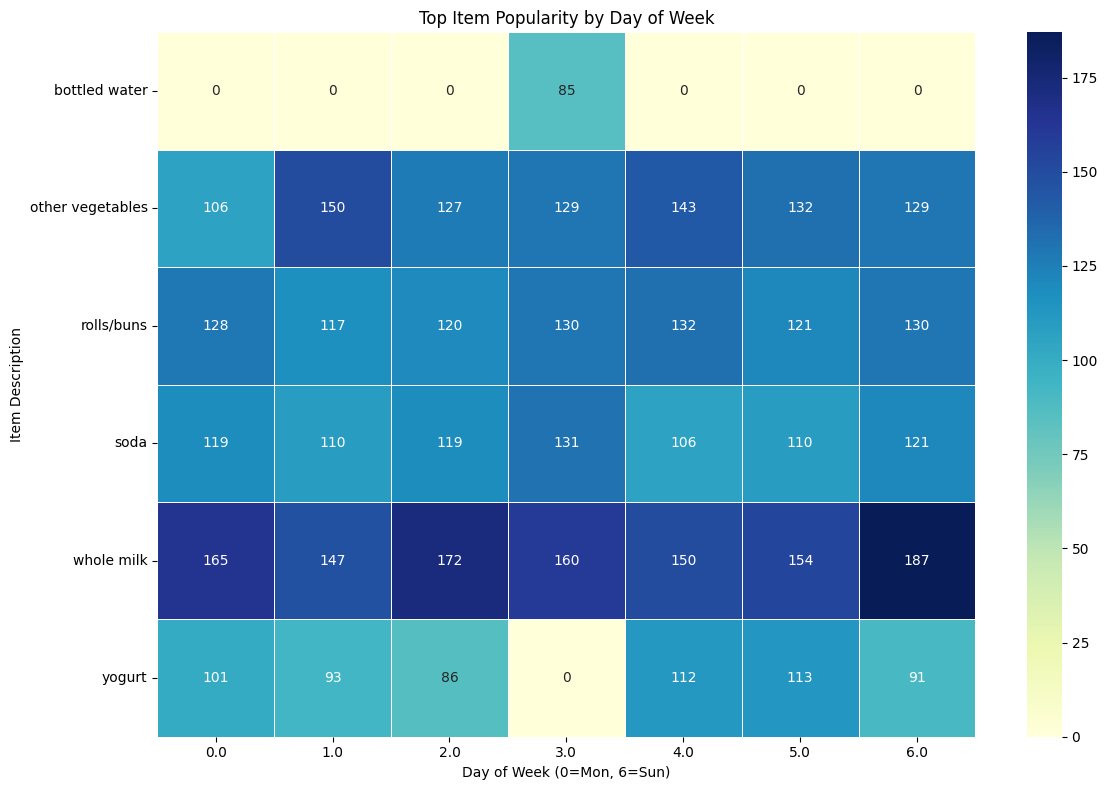

In [20]:
popular_by_day = (
    df_train.groupby(['day_of_week', 'itemdescription'])
    .size()
    .reset_index(name='count')
)

top_items_by_day = (
    popular_by_day.sort_values(['day_of_week', 'count'], ascending=[True, False])
    .groupby('day_of_week')
    .head(5)
    .reset_index(drop=True)
)
display(top_items_by_day)

heatmap_data = top_items_by_day.pivot_table(index='itemdescription', columns='day_of_week', values='count', fill_value=0)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=0.5)
plt.title("Top Item Popularity by Day of Week")
plt.xlabel("Day of Week (0=Mon, 6=Sun)")
plt.ylabel("Item Description")
plt.tight_layout()
plt.show()

We can see that according to day od week, there is no specific patterns, mostly people buy them everyday. There is no specific items that people buy it in specific day of week.

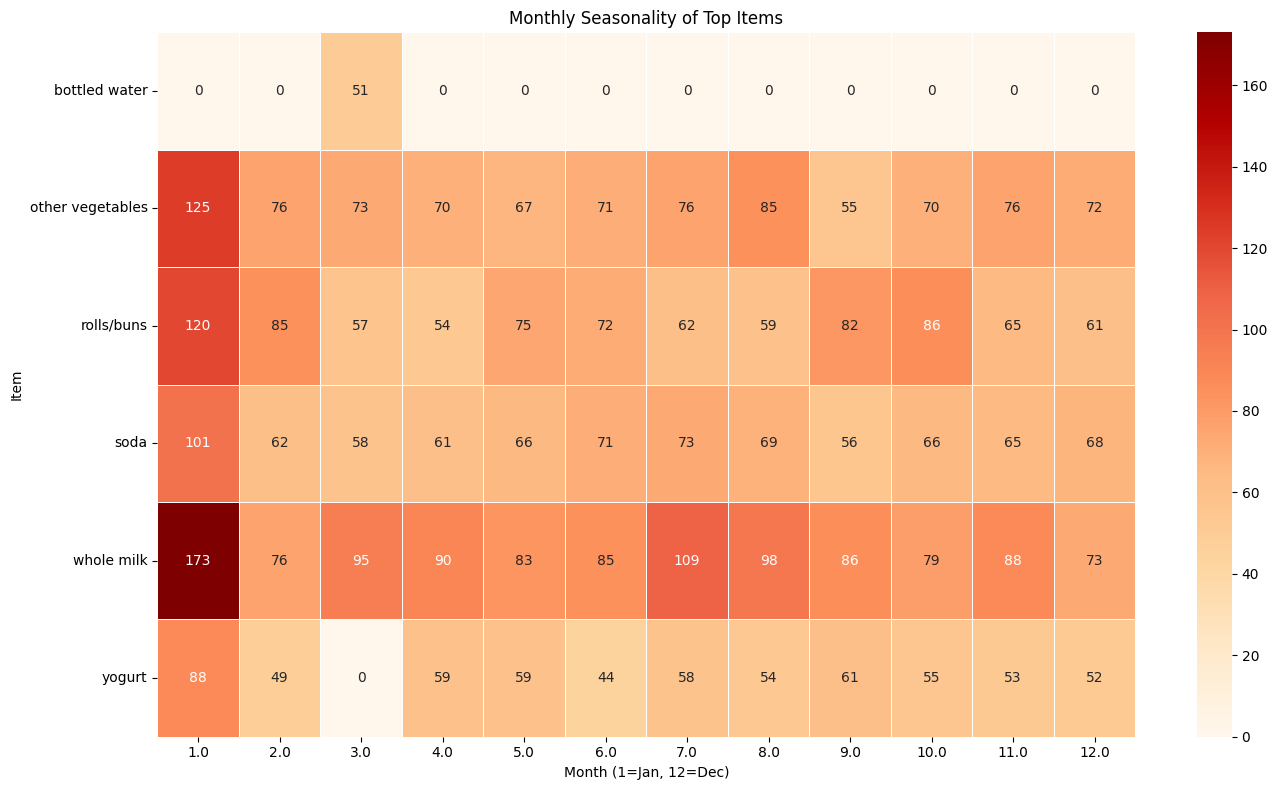

In [21]:
monthly_counts = (
    df_train.groupby(['month', 'itemdescription'])
    .size()
    .reset_index(name='count')
)

top_items_by_month = (
    monthly_counts.sort_values(['month', 'count'], ascending=[True, False])
    .groupby('month')
    .head(5)
    .reset_index(drop=True)
)

heatmap_data_month = top_items_by_month.pivot_table(
    index='itemdescription',
    columns='month',
    values='count',
    fill_value=0
)


plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data_month.astype(int), annot=True, fmt='d', cmap='OrRd', linewidths=0.5)
plt.title("Monthly Seasonality of Top Items")
plt.xlabel("Month (1=Jan, 12=Dec)")
plt.ylabel("Item")
plt.tight_layout()
plt.show()

We explored weekly and monthly item purchase patterns to detect potential seasonality or time-based behaviors. But our heatmap analysis showed no strong or consistent variation in item popularity across days or months.

### 2. Pre-processing data
We will write some functions to help us dealing with data to fit our model.

In [22]:
# ! pip install mlxtend

In [23]:
def preprocess_raw_data(raw_df):
    df = raw_df.copy()
    df.columns = df.columns.str.lower()
    df = df.dropna(subset=['user_id', 'itemdescription', 'date', 'year', 'month', 'day'])
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
    return df

In [24]:
# Filter data based on recent days and/or specific user_id
def filter_data(df, recent_days=None, user_id=None):
    """
    Apply optional filtering based on recent days and/or specific user_id.
    Returns a filtered DataFrame and status message.
    """
    df_filtered = df.copy()

    # Ensure 'date' column is in datetime format
    if 'date' not in df_filtered.columns:
        raise ValueError("DataFrame must contain a 'date' column.")

    if not pd.api.types.is_datetime64_any_dtype(df_filtered['date']):
        df_filtered['date'] = pd.to_datetime(df_filtered['date'], format="%d/%m/%Y")

    # Apply recent_days filter
    if recent_days is not None:
        latest_date = df_filtered['date'].max()
        cutoff = latest_date - pd.Timedelta(days=recent_days)
        df_filtered = df_filtered[df_filtered['date'] >= cutoff]

    # Apply user_id filter
    if user_id is not None:
        df_filtered = df_filtered[df_filtered['user_id'] == user_id]
        if df_filtered.empty:
            return None, "User not found or no records in recent days."

    return df_filtered, "Success"

In [25]:
# Preprocess the training data
data1 = df_train.copy()
df = preprocess_raw_data(data1)
df_train = df.iloc[:-10].copy()
df_val = df.iloc[-10:].copy()

#### 3. Apriori implement

In [26]:
# Apriori Algorithm with Association Rules
def mining_patterns(df, min_support=0.0015, user_items=None):
    # Preprocess the transaction
    df['transaction'] = (
        df['user_id'].astype(str) + '_' +
        df['year'].astype(str) + '_' +
        df['month'].astype(str).str.zfill(2) + '_' +
        df['day'].astype(str).str.zfill(2)
    )
    transactions = df.groupby('transaction')['itemdescription'].apply(list).tolist()

    # Convert transactions to a one-hot encoded DataFrame
    te = TransactionEncoder()
    df_encoded = pd.DataFrame(te.fit(transactions).transform(transactions), columns=te.columns_)
    frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)
    if frequent_itemsets.empty:
        return pd.DataFrame(), "No patterns found"
    # Generate association rules
    rules_conf = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.1)
    rules_lift = association_rules(frequent_itemsets, metric='lift', min_threshold=1.2)
    rules_lev = association_rules(frequent_itemsets, metric='leverage', min_threshold=0.001)

    
    frames = [rules_conf, rules_lift, rules_lev]
    frames = [f for f in frames if not f.empty]
    if not frames:
        return pd.DataFrame(), "No association rules met thresholds"
    rules = pd.concat(frames).drop_duplicates()
    if 'antecedents' not in rules.columns or 'consequents' not in rules.columns:
        return pd.DataFrame(), "Incomplete rules generated"
    
    
    rules['combo_score'] = rules['confidence'] * rules['lift']
    item_freq = df_train['itemdescription'].value_counts(normalize=True)
    # Non-standard metrics
    rules['consequent_freq'] = rules['consequents'].apply(lambda x: item_freq.get(list(x)[0], 0))
    rules['surprise_score'] = (1 - rules['consequent_freq']) * rules['confidence']
    rules['antecedent_freq'] = rules['antecedents'].apply(lambda x: item_freq.get(list(x)[0], 0))
    rules['rec_value'] = rules['lift'] * rules['confidence'] / (rules['antecedent_freq'] + 0.01)
    
    for col in ['rec_value', 'surprise_score']:
        min_val = rules[col].min()
        max_val = rules[col].max()
        rules[col + '_scaled'] = (
            (rules[col] - min_val) / (max_val - min_val)
            if max_val > min_val else 0
        )
    
    if len(rules) > 0:
        for col in ['rec_value', 'surprise_score']:
            min_val = rules[col].min()
            max_val = rules[col].max()
            rules[col + '_scaled'] = (
                (rules[col] - min_val) / (max_val - min_val)
                if max_val > min_val else 0
            )

    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(rules[['confidence', 'lift', 'leverage']])
    rules[['conf_scaled', 'lift_scaled', 'lev_scaled']] = scaled
    rules['NUS'] = rules[['conf_scaled', 'lift_scaled', 'lev_scaled']].mean(axis=1)
    
    if user_items is not None:
        def match_strength(rule):
            antecedents = set(rule['antecedents'])
            overlap = antecedents.intersection(set(user_items))
            return len(overlap) / len(antecedents) if antecedents else 0

        rules['match_strength'] = rules.apply(match_strength, axis=1)
        rules['user_rule_score'] = rules['match_strength'] * (
            0.6 * rules['rec_value_scaled'] + 0.4 * rules['surprise_score_scaled']
        )

    return rules, "Success"

##### Standard metrics
1. Confidence: It tells us the possibility of the consequent occurred given the antecedent. 
2. Lift: It shows the strength of the association. Lift > 1 means the antecedent increases likelihood of the consequent.
3. Leverage: Difference between observed frequency and expected if independent. A small positive value means a mild but meaningful relationship.

##### Non-standard metrics
1. Surprise score: This rule shows the consequent is rare(not in top product) and the rule is still confident. It is good for finding unexpected but strong recommendations.
2. Recommendation value(rec_value): This is useful when we search for small group(niche) recommendation. It is mainly rewards with rare antecedents.
3. user_match_score: Measures how many items in the rule’s antecedents are present in the user’s history.
3. NUS(normalize utility score): This is the score to find overall score across metrics.

In [27]:
# Generate recommendations based on rules
def recommend_from_rules(rules, user_items, top_k=5, metric='rec_value'):
    matched_rules = rules[rules['antecedents'].apply(lambda x: x.issubset(user_items))]
    if matched_rules.empty:
        return []

    sorted_items = (
        matched_rules.sort_values(by=metric, ascending=False)['consequents']
        .apply(lambda x: list(x)[0])  # get 1 item from frozenset
        .drop_duplicates()
        .head(top_k)
        .tolist()
    )
    return sorted_items

In [28]:
# Evaluate our recommendation
def evaluate_recommendation(rules, validation_row, train_data, top_k=5, metric='rec_value'):
    """
    Evaluates how well the top-k recommended items match the user's actual last purchase.
    Handles both Series (single row) and DataFrame (single row).
    """
    # Extract user_id and actual item from the validation row
    if isinstance(validation_row, pd.Series):
        row = validation_row
    elif isinstance(validation_row, pd.DataFrame):
        row = validation_row.iloc[0]
    else:
        raise ValueError("Unsupported validation_row type")
    user_id = row['user_id']
    actual_item = row['itemdescription']

    # Get prior purchases from training
    user_history = train_data[train_data['user_id'] == user_id]['itemdescription'].unique().tolist()
    if not user_history:
        # Fallback: use global top-k items from training data
        popular_items = train_data['itemdescription'].value_counts().head(top_k).index.tolist()
        ap_at_k = 1 / (popular_items.index(actual_item) + 1) if actual_item in popular_items else 0
        rr = 1 / (popular_items.index(actual_item) + 1) if actual_item in popular_items else 0
        return {
            'user_id': user_id,
            'actual_item': actual_item,
            'recommended_items': popular_items,
            'precision@k': int(actual_item in popular_items) / top_k,
            'hit@k': int(actual_item in popular_items),
            'AP@k': ap_at_k,
            'RR': rr,
            'details': [],
            'Reason': 'No user history, fallback to popular items'
        }
    # Filter rules where antecedents are in user history
    matched_rules = rules[rules['antecedents'].apply(lambda x: x.issubset(user_history))]
    
    if matched_rules.empty:
        popular_items = train_data['itemdescription'].value_counts().head(top_k).index.tolist()
        ap_at_k = 1 / (popular_items.index(actual_item) + 1) if actual_item in popular_items else 0
        rr = 1 / (popular_items.index(actual_item) + 1) if actual_item in popular_items else 0
        return {
            'user_id': user_id,
            'actual_item': actual_item,
            'recommended_items': popular_items,
            'precision@k': int(actual_item in popular_items) / top_k,
            'hit@k': int(actual_item in popular_items),
            'AP@k': ap_at_k,
            'RR': rr,
            'details': [],
            'Reason': 'No matched rules, fallback to popular items'
        }
    
    # Sort by the given metric
    top_rules = matched_rules.sort_values(by=metric, ascending=False).head(top_k)
    recommended_items = list(top_rules['consequents'].explode().drop_duplicates().head(top_k))
    
    # Save scores for the recommended items
    if not matched_rules.empty:
        matched_recs = top_rules[['consequents', 'confidence', 'lift', 'rec_value']].copy()
        matched_recs['consequents'] = matched_recs['consequents'].apply(lambda x: list(x)[0])
        matched_recs = matched_recs[matched_recs['consequents'].isin(recommended_items)]
        rec_scores = matched_recs.to_dict(orient='records')
    else:
        rec_scores = {}
    # Evaluate
    precision_at_k = int(actual_item in recommended_items) / top_k
    hit_at_k = int(actual_item in recommended_items)

    # AP@k
    try:
        rank = recommended_items.index(actual_item) + 1
        ap_at_k = 1 / rank
        rr = 1 / rank
    except ValueError:
        ap_at_k = 0
        rr = 0

    return {
        'user_id': user_id,
        'actual_item': actual_item,
        'recommended_items': recommended_items,
        'precision@k': precision_at_k,
        'hit@k': hit_at_k,
        'AP@k': ap_at_k,
        'RR': rr,
        'details': rec_scores,
        'Reason': 'Rule-based recommendation'
    }

1. precision@k: The proportion of recommended items in the top k that are actually relevant.
2. hit@k: A binary indicator — 1 if the actual item appears in the top k recommendations, 0 otherwise.
3. AP@k (Average Precision at k):  Measures not only show the correct item is in the top-k list but also where it appears. The earlier (higher ranked), the better the score.
4. RR (Reciprocal Rank): Reciprocal of the rank of the first correct item in the recommendation list.

We don't use f1 or recall because recall requires multiple relevant items per user, but we have only one actual item. And f1 score combines precision and recall, so with only one true label, it is equivalent to precision and provides no extra details.

In [29]:
# Mining patterns from training data
rules, msg = mining_patterns(df_train, min_support=0.0015)
print("Total rules mined:", len(rules))
display(rules.head(10))


Total rules mined: 25


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,...,consequent_freq,surprise_score,antecedent_freq,rec_value,rec_value_scaled,surprise_score_scaled,conf_scaled,lift_scaled,lev_scaled,NUS
0,(UHT-milk),(other vegetables),0.019854,0.106686,0.002153,0.108434,1.016384,1.0,0.000035,1.001961,...,0.047285,0.103306,0.008621,5.918702,0.414621,0.620900,0.614531,0.286020,0.569948,0.490166
1,(bottled beer),(whole milk),0.040426,0.130367,0.005382,0.133136,1.021239,1.0,0.000112,1.003194,...,0.058538,0.125343,0.017706,4.907384,0.340113,0.776745,0.778047,0.291590,0.613776,0.561138
2,(candy),(whole milk),0.016027,0.130367,0.002153,0.134328,1.030385,1.0,0.000063,1.004576,...,0.058538,0.126465,0.007072,8.107391,0.575871,0.784683,0.785939,0.302082,0.586281,0.558100
3,(cat food),(whole milk),0.014233,0.130367,0.001794,0.126050,0.966888,1.0,-0.000061,0.995061,...,0.058538,0.118672,0.006143,7.549864,0.534796,0.729567,0.731143,0.229238,0.515387,0.491923
4,(frankfurter),(whole milk),0.012199,0.130367,0.002033,0.166667,1.278440,1.0,0.000443,1.043559,...,0.058538,0.156910,0.005369,13.864227,1.000000,1.000000,1.000000,0.586652,0.801559,0.796070
5,(frozen vegetables),(whole milk),0.027509,0.130367,0.002751,0.100000,0.767064,1.0,-0.000835,0.966259,...,0.058538,0.094146,0.012131,3.466031,0.233923,0.556116,0.558704,0.000000,0.076194,0.211633
6,(fruit/vegetable juice),(rolls/buns),0.036718,0.101902,0.003708,0.100977,0.990928,1.0,-0.000034,0.998972,...,0.045323,0.096401,0.016157,3.825354,0.260396,0.572060,0.565173,0.256817,0.530990,0.450993
7,(hamburger meat),(rolls/buns),0.017223,0.101902,0.001794,0.104167,1.022227,1.0,0.000039,1.002528,...,0.045323,0.099446,0.007433,6.107927,0.428562,0.593594,0.586285,0.292723,0.572391,0.483800
8,(ice cream),(whole milk),0.012558,0.130367,0.001555,0.123810,0.949699,1.0,-0.000082,0.992516,...,0.058538,0.116562,0.005420,7.625178,0.540344,0.714646,0.716310,0.209518,0.503519,0.476449
9,(long life bakery product),(whole milk),0.020332,0.130367,0.002033,0.100000,0.767064,1.0,-0.000617,0.966259,...,0.058538,0.094146,0.008827,4.074240,0.278732,0.556116,0.558704,0.000000,0.199862,0.252855


We got the scores from the columns and there are 25 columns matched our rules. The results show the strong trend of items like whole milk frequently appearing as consequents. This may limited the diversity of all items.

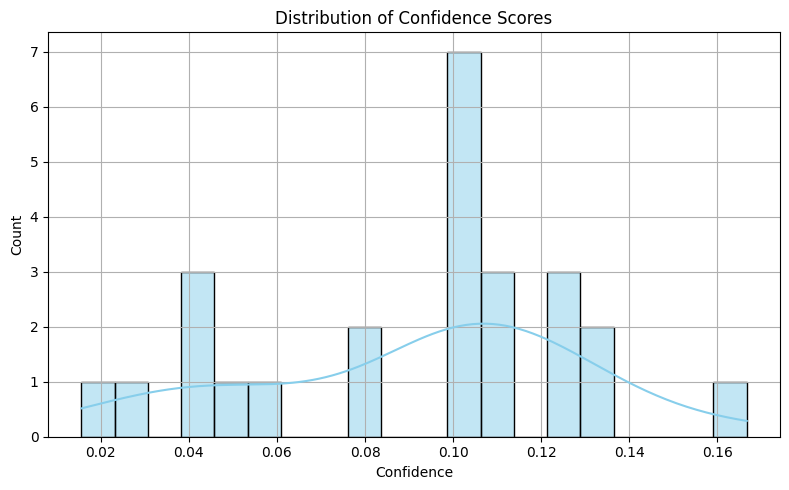

In [30]:
# Histogram of Confidence Scores
plt.figure(figsize=(8, 5))
sns.histplot(rules['confidence'], bins=20, kde=True, color='skyblue')
plt.title("Distribution of Confidence Scores")
plt.xlabel("Confidence")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

The graph shows us the distribution of confidence score, and it shows that overall score is not high enough to indicate low reliability. Although it can give us some suggestions but not accurate enough for every user.

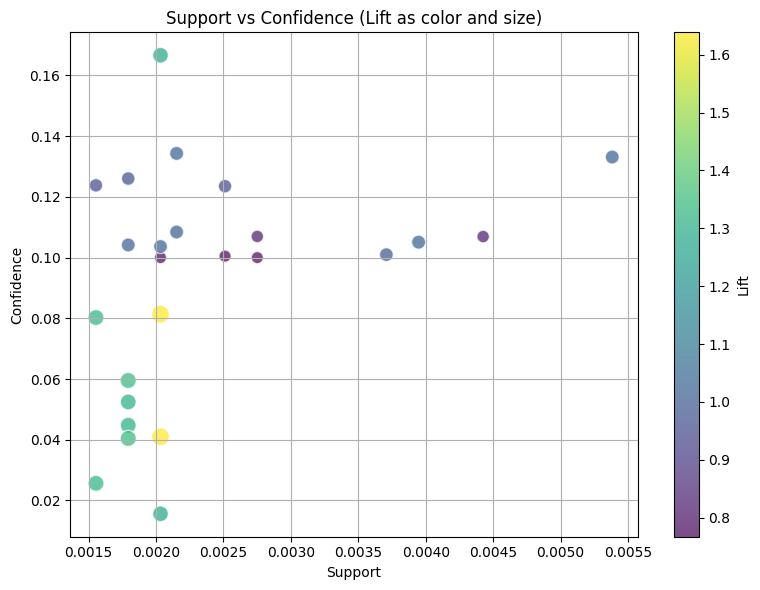

In [31]:
# Support vs Confidence (colored/sized by Lift)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    rules['support'], rules['confidence'],
    c=rules['lift'], s=rules['lift'] * 100, cmap='viridis', alpha=0.7, edgecolors='w'
)
plt.colorbar(scatter, label='Lift')
plt.title("Support vs Confidence (Lift as color and size)")
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.grid(True)
plt.tight_layout()
plt.show()

This graph didn't give us any strong patterns. We can see in low support, the distribution of confidence is kind of evenly. But in higher support, it shows the confidence mainly distribute in moderate.

/var/folders/0l/qgn1vqn15c3gw9rx0_bhcwq40000gn/T/ipykernel_56049/2268003209.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


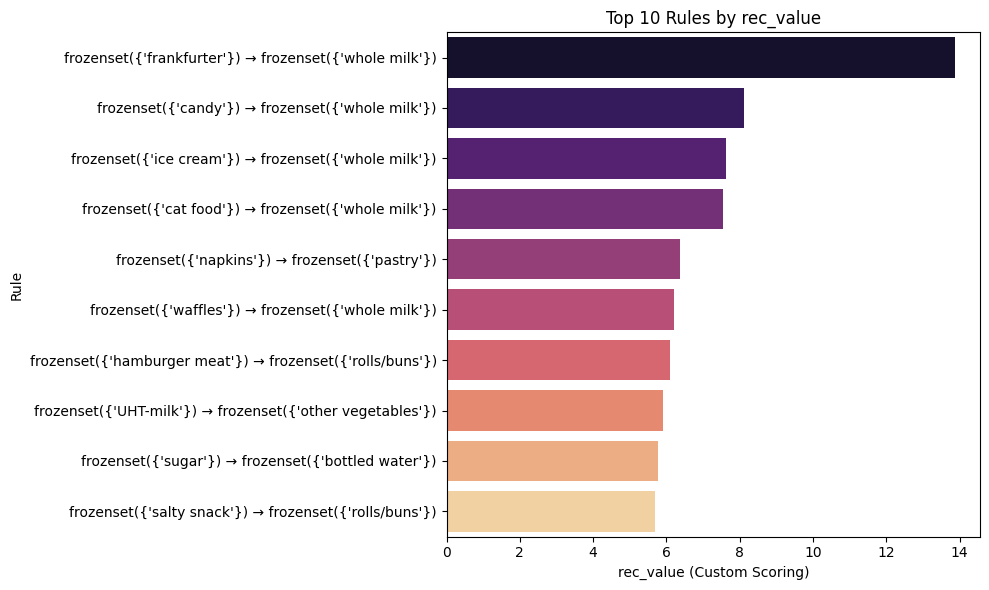

In [32]:
# Bar Chart: Top 10 Rules by rec_value
top_rec = rules.sort_values(by='rec_value', ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_rec,
    x='rec_value',
    y=top_rec['antecedents'].astype(str) + " → " + top_rec['consequents'].astype(str),
    palette='magma'
)
plt.title("Top 10 Rules by rec_value")
plt.xlabel("rec_value (Custom Scoring)")
plt.ylabel("Rule")
plt.tight_layout()
plt.show()


Whole milk frequently appears as a strong consequent across varied antecedents. From the data analysis part, we also can see that whole milk is the one of most popular items. So this consequent make sense.

In [33]:
# Test with validation data
results = []
for i in range(len(df_val)):
    row = df_val.iloc[[i]]
    eval_result = evaluate_recommendation(rules, row, train_data=df_train, top_k=5)
    results.append(eval_result)

results_df = pd.DataFrame(results)
display(results_df)

# MAP@10
map_10 = results_df['AP@k'].mean()
print(f"MAP@10: {map_10:.4f}")

,user_id,actual_item,recommended_items,precision@k,hit@k,AP@k,RR,details,Reason
0,2430.0,specialty bar,"[whole milk, rolls/buns, napkins]",0.0,0,0.0,0.0,"[{'consequents': 'whole milk', 'confidence': 0...",Rule-based recommendation
1,1967.0,brown bread,"[rolls/buns, frankfurter]",0.0,0,0.0,0.0,"[{'consequents': 'rolls/buns', 'confidence': 0...",Rule-based recommendation
2,1001.0,soda,"[whole milk, frankfurter]",0.0,0,0.0,0.0,"[{'consequents': 'whole milk', 'confidence': 0...",Rule-based recommendation
3,3985.0,bottled beer,[sugar],0.0,0,0.0,0.0,"[{'consequents': 'sugar', 'confidence': 0.0256...",Rule-based recommendation
4,2235.0,whole milk,"[whole milk, brown bread]",0.2,1,1.0,1.0,"[{'consequents': 'whole milk', 'confidence': 0...",Rule-based recommendation
5,3575.0,bottled water,"[whole milk, other vegetables, rolls/buns, sod...",0.0,0,0.0,0.0,[],"No matched rules, fallback to popular items"
6,2075.0,root vegetables,[whole milk],0.0,0,0.0,0.0,"[{'consequents': 'whole milk', 'confidence': 0...",Rule-based recommendation
7,3797.0,cream,"[whole milk, rolls/buns, frankfurter]",0.0,0,0.0,0.0,"[{'consequents': 'whole milk', 'confidence': 0...",Rule-based recommendation
8,4390.0,coffee,[frankfurter],0.0,0,0.0,0.0,"[{'consequents': 'frankfurter', 'confidence': ...",Rule-based recommendation
9,2544.0,frozen potato products,[whole milk],0.0,0,0.0,0.0,"[{'consequents': 'whole milk', 'confidence': 0...",Rule-based recommendation


MAP@10: 0.1000


We pick the last 10 columns as the validation, and overall the performance of the apriori isn't well. It shows most of the users receiving irrelevant recommendations. There is only one case shows the hit. It means according to our rules has limited coverage.

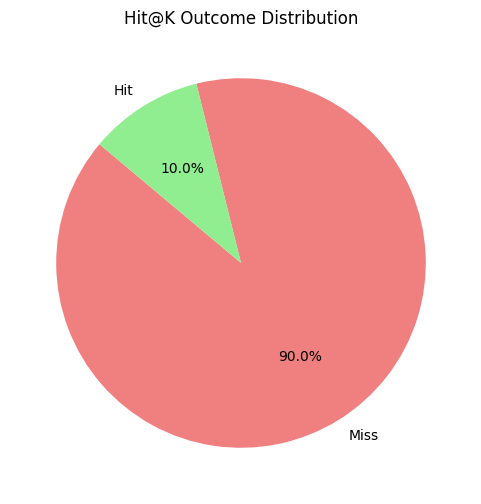

In [34]:
hit_counts = results_df['hit@k'].value_counts().sort_index()
labels = ['Miss', 'Hit']
plt.figure(figsize=(6, 6))
plt.pie(hit_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=['lightcoral', 'lightgreen'])
plt.title('Hit@K Outcome Distribution')
plt.show()

### 4. Dealing with raw data

In [35]:

def raw_data_mining(raw_df, user_id, recent_days=30, min_support=0.0015, top_k=5):
    
    # Preprocess raw data
    df = preprocess_raw_data(raw_df)
    # Check if user exists
    user_id = int(user_id) if user_id is not None else None
    user_in_data = user_id in df['user_id'].unique() if user_id is not None else False
    
    if user_in_data:
        filtered_df, msg = filter_data(df, recent_days=recent_days, user_id=user_id)
        if filtered_df is None or filtered_df.empty:
            return {
                'mode': 'user mode (but no records)',
                'recommended_items': df['itemdescription'].value_counts().head(top_k).index.tolist(),
                'reason': msg
            }
    else:
        filtered_df, msg = filter_data(df, recent_days=recent_days)
        if filtered_df is None or filtered_df.empty:
            return {
                'mode': 'global mode (no data in recent_days)',
                'recommended_items': df['itemdescription'].value_counts().head(top_k).index.tolist(),
                'reason': msg
            }
            
    # Pattern mining
    user_items = (
        filtered_df[filtered_df['user_id'].astype(str) == str(user_id)]['itemdescription'].unique().tolist()
        if user_id is not None and user_in_data else []
    )
    
    rules, _ = mining_patterns(filtered_df, min_support=min_support, user_items=user_items)
    
    if rules.empty or 'antecedents' not in rules.columns:
        fallback_items = filtered_df['itemdescription'].value_counts().head(top_k).index.tolist()
        return {
            'mode': 'user mode (no rules)' if user_in_data else 'global mode (no rules)',
            'recommended_items': fallback_items,
            'reason': 'No association rules could be generated',
            'top_rules': pd.DataFrame(columns=[
                'antecedents', 'consequents', 'support', 'confidence', 'lift',
                'combo_score', 'surprise_score', 'rec_value', 'NUS', 'user_rule_score'
            ])
        }
    
    # Generate recommendations from rules
    

    recommended_items = recommend_from_rules(rules, user_items, top_k=top_k)

    if not recommended_items:
        fallback_items = filtered_df['itemdescription'].value_counts().head(top_k).index.tolist()
        return {
            'mode': 'user mode' if user_in_data else 'global mode',
            'recommended_items': fallback_items,
            'reason': 'No matched rules, fallback to popular items'
        }

    return {
        'mode': 'user mode with rules' if user_in_data else 'global mode with rules',
        'recommended_items': recommended_items,
        'reason': 'Rules matched and used'
    }

The function takes raw transactional data and returns top-k item recommendations according to rules. It also support user-specific and global modes by checking if the user has sufficient recent history.

In [36]:
# Example of using raw data
raw_df = df_val.copy()

# Apply the same preprocessing used in training
raw_df = preprocess_raw_data(raw_df)

# Run the recommendation module for a specific user
output_user = raw_data_mining(
    raw_df,
    user_id=2430,            
    recent_days=344,     
    min_support=0.0015,
    top_k=5
)
print("User-Specific Output:")
print(output_user)

# The top 5 items for all users
output_global = raw_data_mining(
    raw_df,
    user_id=None,
    recent_days=344,
    min_support=0.0015,
    top_k=5
)

display(output_global)

User-Specific Output:
{'mode': 'user mode (no rules)', 'recommended_items': ['specialty bar'], 'reason': 'No association rules could be generated', 'top_rules': Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift, combo_score, surprise_score, rec_value, NUS, user_rule_score]
Index: []}


{'mode': 'global mode (no rules)',
 'recommended_items': ['specialty bar',
  'brown bread',
  'soda',
  'bottled beer',
  'whole milk'],
 'reason': 'No association rules could be generated',
 'top_rules': Empty DataFrame
 Columns: [antecedents, consequents, support, confidence, lift, combo_score, surprise_score, rec_value, NUS, user_rule_score]
 Index: []}

The result shows according to user_id 2430(example) and the model recommendate those 5 items. And for the second part is using global mode to show overall the top 5 item recommendations.

In [37]:
import pickle
import os

data1 = preprocess_raw_data(data1)

# Mine patterns from the full training data
rules, msg = mining_patterns(data1, min_support=0.0015)
# Save rules to a file
rules_path = 'saved_rules.pkl'

# Check if the file exists
if os.path.exists(rules_path):
    with open(rules_path, 'rb') as f:
        rules = pickle.load(f)
    print("Loaded rules from saved_rules.pkl")
else:
    rules, msg = mining_patterns(data1, min_support=0.0015)
    with open(rules_path, 'wb') as f:
        pickle.dump(rules, f)
    print(f"{msg} — Rules mined and saved to saved_rules.pkl")

# STEP 3: Evaluate raw data users
raw_sorted = raw_df.sort_values(by=['user_id', 'date'])
df_val = raw_sorted.groupby('user_id').tail(1)
print(df_val.shape)

results = []

for _, row in df_val.iterrows():
    user_id = row['user_id']
    user_history = data1[data1['user_id'] == user_id]

    if user_history.empty:
        continue  

    result = evaluate_recommendation(
        rules,
        validation_row=row,
        train_data=user_history,
        top_k=5,
        metric='rec_value'
    )
    results.append(result)

results_df = pd.DataFrame(results)
print(f"MAP@10: {results_df['AP@k'].mean():.4f}")
display(results_df[['user_id', 'actual_item', 'recommended_items', 'precision@k', 'AP@k', 'RR']])


Loaded rules from saved_rules.pkl
(10, 7)
MAP@10: 0.1000


,user_id,actual_item,recommended_items,precision@k,AP@k,RR
0,1001.0,soda,"[whole milk, frankfurter]",0.0,0.0,0.0
1,1967.0,brown bread,"[rolls/buns, canned beer, frankfurter]",0.0,0.0,0.0
2,2075.0,root vegetables,[whole milk],0.0,0.0,0.0
3,2235.0,whole milk,"[whole milk, brown bread, frankfurter]",0.2,1.0,1.0
4,2430.0,specialty bar,"[whole milk, rolls/buns, napkins]",0.0,0.0,0.0
5,2544.0,frozen potato products,[whole milk],0.0,0.0,0.0
6,3575.0,bottled water,[sugar],0.0,0.0,0.0
7,3797.0,cream,"[whole milk, rolls/buns, frankfurter]",0.0,0.0,0.0
8,3985.0,bottled beer,"[whole milk, sugar]",0.0,0.0,0.0
9,4390.0,coffee,[frankfurter],0.0,0.0,0.0


Here we test our apriori by using validation dataset. And also we save our rules to make sure those rules are constant and not bothering everytime when somebody insert new user_id.

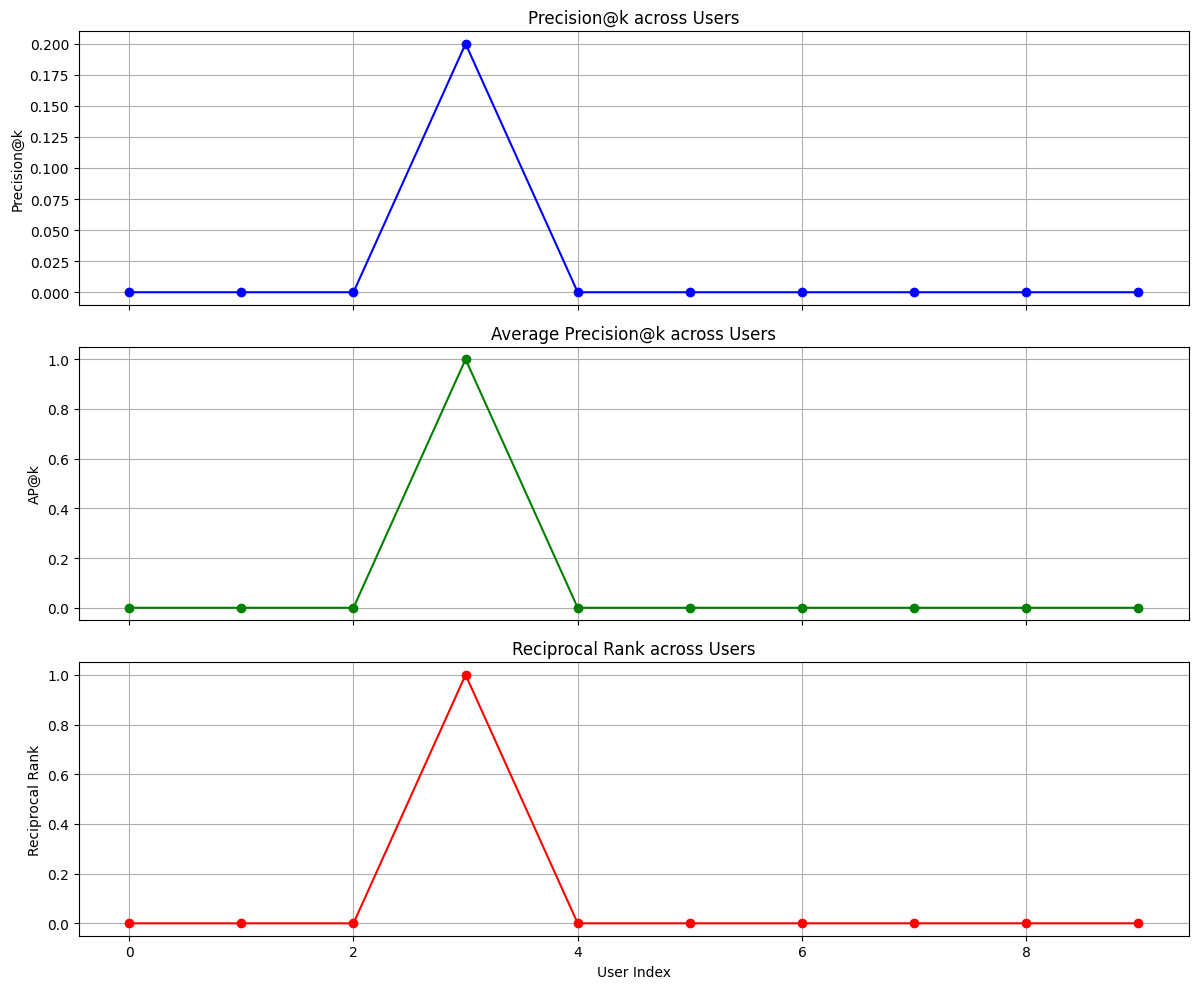

In [38]:
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Plot Precision@k
axs[0].plot(results_df.index, results_df['precision@k'], marker='o', linestyle='-', color='blue')
axs[0].set_ylabel('Precision@k')
axs[0].set_title('Precision@k across Users')
axs[0].grid(True)

# Plot AP@k
axs[1].plot(results_df.index, results_df['AP@k'], marker='o', linestyle='-', color='green')
axs[1].set_ylabel('AP@k')
axs[1].set_title('Average Precision@k across Users')
axs[1].grid(True)

# Plot RR
axs[2].plot(results_df.index, results_df['RR'], marker='o', linestyle='-', color='red')
axs[2].set_ylabel('Reciprocal Rank')
axs[2].set_xlabel('User Index')
axs[2].set_title('Reciprocal Rank across Users')
axs[2].grid(True)

plt.tight_layout()
plt.show()

This plot shows that while a few users achieved high Precision@k, AP@k, and Reciprocal Rank, most had zero scores—indicating their actual purchase was not among top-k recommendations. The sparse distribution suggests rule coverage could be expanded or better personalized to improve model effectiveness across all users.

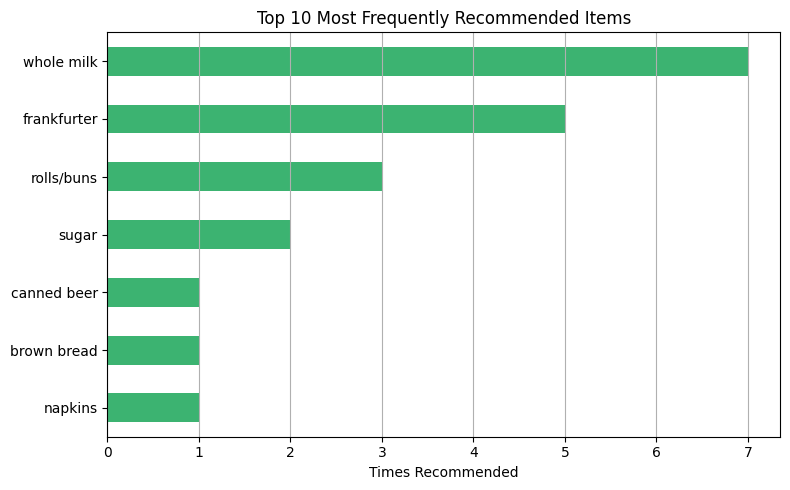

In [39]:
from collections import Counter

all_recs = results_df['recommended_items'].explode()
top_items = pd.Series(Counter(all_recs)).nlargest(10)

top_items.plot(kind='barh', figsize=(8,5), color='mediumseagreen')
plt.xlabel('Times Recommended')
plt.title('Top 10 Most Frequently Recommended Items')
plt.gca().invert_yaxis()
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

Here shows the top 10 item recommendation and with no surprise that whole milk is the top 1 item. It only shows 7 items is because our validation dataset only contains 10 items.

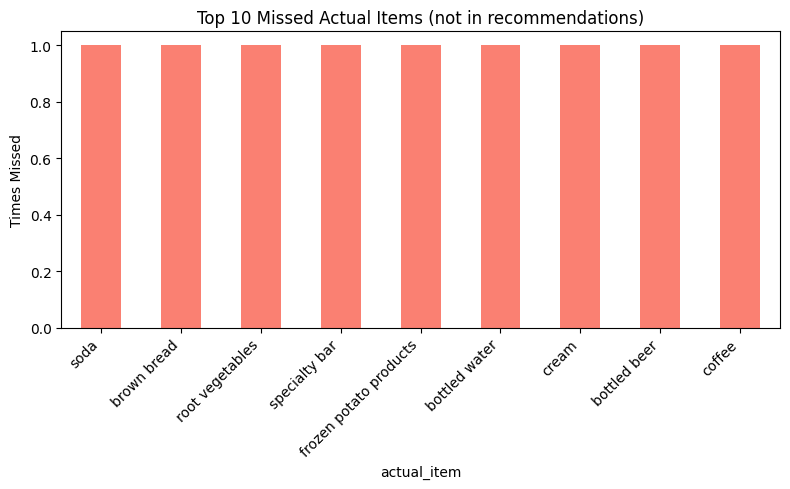

In [40]:
misses = results_df[results_df['hit@k'] == 0]
miss_counts = misses['actual_item'].value_counts().head(10)

miss_counts.plot(kind='bar', figsize=(8, 5), color='salmon')
plt.ylabel('Times Missed')
plt.title('Top 10 Missed Actual Items (not in recommendations)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Here shows how many times the recommendation missed by items. This means the gaps of rule converage or item frequency thresholds may need some adjustments.

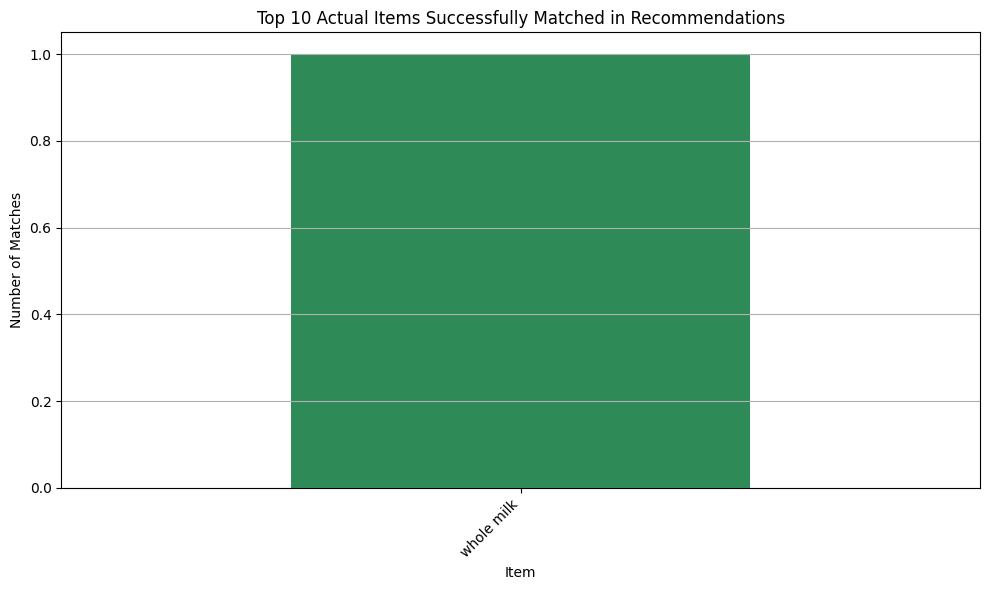

In [41]:
matched_items = results_df[results_df['hit@k'] == 1]['actual_item'].value_counts().head(10)

plt.figure(figsize=(10, 6))
matched_items.plot(kind='bar', color='seagreen')
plt.title('Top 10 Actual Items Successfully Matched in Recommendations')
plt.xlabel('Item')
plt.ylabel('Number of Matches')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

This result shows there are really low accuracy from the recommendation. It means we have a huge chances to improve our model. From the top item recommendations we always see whole milk, other vegetables, soda...etc. It means our rules do not cover enough user scenarios to show the high performance.  As the result shows, apriori seems not a good option in this case. In the future, we can use either FP-growth or ECLAT.

### 5. Reference

1. Lee, C.H., Kim, Y.H. and Rhee, P.K., 2001. Web personalization expert with combining collaborative filtering and association rule mining technique. Expert Systems with Applications, 21(3), pp.131-137.
2. Parvatikar, S. and Joshi, B., 2015, December. Online book recommendation system by using collaborative filtering and association mining. In 2015 IEEE International Conference on Computational Intelligence and Computing Research (ICCIC) (pp. 1-4). IEEE.
3. https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173
4. 